<a href="https://colab.research.google.com/github/pkmariya/Scaler01/blob/master/ZeeRecommender_CaseStudy_Mariya_DSML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
The Objective is to create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

In [168]:
# Import required libraries
# Libraries for Data Processing
import numpy as np
import pandas as pd
import scipy.stats
import re
import io

# Libraries for Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries for Similarity check
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
uploaded = files.upload()

Saving zee-ratings.dat to zee-ratings.dat
Saving zee-movies.dat to zee-movies.dat
Saving zee-users.dat to zee-users.dat


In [169]:
for fn in uploaded.keys():
  print('The file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

NameError: ignored

In [5]:
users = pd.read_csv('zee-users.dat', sep='::', usecols=['UserID', "Gender", 'Age', 'Occupation', 'Zip-code'])
users.to_csv ('zee-users.csv', index=None)

In [6]:
movies = pd.read_csv('zee-movies.dat', sep='::', encoding='windows-1252', usecols=['Movie ID', 'Title', 'Genres'])
movies.to_csv('zee-movies.csv', index=None)
# movies_df = pd.read_csv(io.StringIO(uploaded['zee-movies.dat'].decode('utf-8')))

In [7]:
ratings = pd.read_csv('zee-ratings.dat', sep='::', usecols=['UserID', 'MovieID', 'Rating', 'Timestamp'])
ratings.to_csv ('zee-ratings.csv', index=None)

In [71]:
user_df = pd.read_csv('zee-users.csv')
movies_df = pd.read_csv('zee-movies.csv')
ratings_df = pd.read_csv('zee-ratings.csv')

In [9]:
user_df.describe(include='all')

,UserID,Gender,Age,Occupation,Zip-code
count,6040.000000,6040,6040.000000,6040.000000,6040
unique,NaN,2,NaN,NaN,3439
top,NaN,M,NaN,NaN,48104
freq,NaN,4331,NaN,NaN,19
mean,3020.500000,NaN,30.639238,8.146854,NaN
std,1743.742145,NaN,12.895962,6.329511,NaN
min,1.000000,NaN,1.000000,0.000000,NaN
25%,1510.750000,NaN,25.000000,3.000000,NaN
50%,3020.500000,NaN,25.000000,7.000000,NaN
75%,4530.250000,NaN,35.000000,14.000000,NaN


In [10]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   int64 
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   int64 
 3   Occupation  6040 non-null   int64 
 4   Zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [11]:
user_df.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [12]:
user_df.nunique()

UserID        6040
Gender           2
Age              7
Occupation      21
Zip-code      3439
dtype: int64

In [13]:
movies_df.describe(include='all')

,Movie ID,Title,Genres
count,3883.000000,3883,3883
unique,NaN,3883,301
top,NaN,Toy Story (1995),Drama
freq,NaN,1,843
mean,1986.049446,NaN,NaN
std,1146.778349,NaN,NaN
min,1.000000,NaN,NaN
25%,982.500000,NaN,NaN
50%,2010.000000,NaN,NaN
75%,2980.500000,NaN,NaN


In [72]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Movie ID  3883 non-null   int64 
 1   Title     3883 non-null   object
 2   Genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [15]:
movies_df.head()

,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [16]:
movies_df.nunique()

Movie ID    3883
Title       3883
Genres       301
dtype: int64

In [17]:
ratings_df.describe(include='all')

,UserID,MovieID,Rating,Timestamp
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


In [18]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [170]:
# Number of users
print('The ratings dataset has', ratings_df['UserID'].nunique(), 'unique users')
# Number of movies
print('The ratings dataset has', ratings_df['MovieID'].nunique(), 'unique movies')
# Number of ratings
print('The ratings dataset has', ratings_df['Rating'].nunique(), 'unique ratings')
# List of unique ratings
print('The unique ratings are', sorted(ratings_df['Rating'].unique()))

The ratings dataset has 6040 unique users
The ratings dataset has 3706 unique movies
The ratings dataset has 5 unique ratings
The unique ratings are [1, 2, 3, 4, 5]


In [19]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [20]:
# Shape of the datasets
print("Users dataset contains {0} Rows and {1} Columns".format(user_df.shape[0], user_df.shape[1]))
print("Movies dataset contains {0} Rows and {1} Columns".format(movies_df.shape[0], movies_df.shape[1]))
print("Ratings dataset contains {0} Rows and {1} Columns".format(ratings_df.shape[0], ratings_df.shape[1]))

Users dataset contains 6040 Rows and 5 Columns
Movies dataset contains 3883 Rows and 3 Columns
Ratings dataset contains 1000209 Rows and 4 Columns


In [21]:
# Check if common users exist b/w user_df and ratings_df
common_users = ratings_df[~ratings_df['UserID'].isin(user_df)]

In [22]:
common_users.nunique()

UserID         6040
MovieID        3706
Rating            5
Timestamp    458455
dtype: int64

In [23]:
# Check if common movies exist b/w movies_df and ratings_df
common_movieID = ratings_df[~ratings_df['MovieID'].isin(movies_df)]

In [24]:
common_movieID.nunique()

UserID         6040
MovieID        3706
Rating            5
Timestamp    458455
dtype: int64

In [73]:
# Align the columns names b/w the datasets
movies_df.rename(columns={'Movie ID': 'MovieID'}, inplace=True)

In [26]:
# Merge movies_df and ratings_df
movie_rating_df = ratings_df.merge(movies_df, how='right', on='MovieID')

In [27]:
movie_rating_df.nunique()

UserID         6040
MovieID        3883
Rating            5
Timestamp    458455
Title          3883
Genres          301
dtype: int64

In [29]:
# Merge user_df and movie_rating_df
final_df = user_df.merge(movie_rating_df, how='right', on='UserID')

In [30]:
final_df.nunique()

UserID          6040
Gender             2
Age                7
Occupation        21
Zip-code        3439
MovieID         3883
Rating             5
Timestamp     458455
Title           3883
Genres           301
dtype: int64

In [31]:
# Description of final_df of all three datasets
final_df.describe(include='all')

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Rating,Timestamp,Title,Genres
count,1.000209e+06,1000209,1.000209e+06,1.000209e+06,1000209,1.000386e+06,1.000209e+06,1.000209e+06,1000386,1000386
unique,NaN,2,NaN,NaN,3439,NaN,NaN,NaN,3883,301
top,NaN,M,NaN,NaN,94110,NaN,NaN,NaN,American Beauty (1999),Comedy
freq,NaN,753769,NaN,NaN,3802,NaN,NaN,NaN,3428,116905
mean,3.024512e+03,NaN,2.973831e+01,8.036138e+00,NaN,1.865526e+03,3.581564e+00,9.722437e+08,NaN,NaN
std,1.728413e+03,NaN,1.175198e+01,6.531336e+00,NaN,1.096030e+03,1.117102e+00,1.215256e+07,NaN,NaN
min,1.000000e+00,NaN,1.000000e+00,0.000000e+00,NaN,1.000000e+00,1.000000e+00,9.567039e+08,NaN,NaN
25%,1.506000e+03,NaN,2.500000e+01,2.000000e+00,NaN,1.030000e+03,3.000000e+00,9.653026e+08,NaN,NaN
50%,3.070000e+03,NaN,2.500000e+01,7.000000e+00,NaN,1.835000e+03,4.000000e+00,9.730180e+08,NaN,NaN
75%,4.476000e+03,NaN,3.500000e+01,1.400000e+01,NaN,2.770000e+03,4.000000e+00,9.752209e+08,NaN,NaN


In [32]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000386 entries, 0 to 1000385
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   UserID      1000209 non-null  float64
 1   Gender      1000209 non-null  object 
 2   Age         1000209 non-null  float64
 3   Occupation  1000209 non-null  float64
 4   Zip-code    1000209 non-null  object 
 5   MovieID     1000386 non-null  int64  
 6   Rating      1000209 non-null  float64
 7   Timestamp   1000209 non-null  float64
 8   Title       1000386 non-null  object 
 9   Genres      1000386 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 84.0+ MB


In [33]:
final_df.head()

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Rating,Timestamp,Title,Genres
0,1.0,F,1.0,10.0,48067,1,5.0,978824268.0,Toy Story (1995),Animation|Children's|Comedy
1,6.0,F,50.0,9.0,55117,1,4.0,978237008.0,Toy Story (1995),Animation|Children's|Comedy
2,8.0,M,25.0,12.0,11413,1,4.0,978233496.0,Toy Story (1995),Animation|Children's|Comedy
3,9.0,M,25.0,17.0,61614,1,5.0,978225952.0,Toy Story (1995),Animation|Children's|Comedy
4,10.0,F,35.0,1.0,95370,1,5.0,978226474.0,Toy Story (1995),Animation|Children's|Comedy


In [34]:
print("Shape of final_df is: ", final_df.shape)

Shape of final_df is:  (1000386, 10)


In [35]:
# Check if missing values exist
final_df.isna().sum()

UserID        177
Gender        177
Age           177
Occupation    177
Zip-code      177
MovieID         0
Rating        177
Timestamp     177
Title           0
Genres          0
dtype: int64

In [36]:
# Remove Missing values
final_df = final_df[final_df['UserID'].notna()]

In [37]:
final_df.isna().sum()

UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
MovieID       0
Rating        0
Timestamp     0
Title         0
Genres        0
dtype: int64

In [38]:
final_df.describe().T

,count,mean,std,min,25%,50%,75%,max
UserID,1000209.0,3.024512e+03,1.728413e+03,1.0,1506.0,3070.0,4476.0,6.040000e+03
Age,1000209.0,2.973831e+01,1.175198e+01,1.0,25.0,25.0,35.0,5.600000e+01
Occupation,1000209.0,8.036138e+00,6.531336e+00,0.0,2.0,7.0,14.0,2.000000e+01
MovieID,1000209.0,1.865540e+03,1.096041e+03,1.0,1030.0,1835.0,2770.0,3.952000e+03
Rating,1000209.0,3.581564e+00,1.117102e+00,1.0,3.0,4.0,4.0,5.000000e+00
Timestamp,1000209.0,9.722437e+08,1.215256e+07,956703932.0,965302637.0,973018006.0,975220939.0,1.046455e+09


In [60]:
num_features = final_df.select_dtypes('number')

In [57]:
cat_features = final_df.select_dtypes('object')

<Axes: xlabel='Gender', ylabel='UserID'>

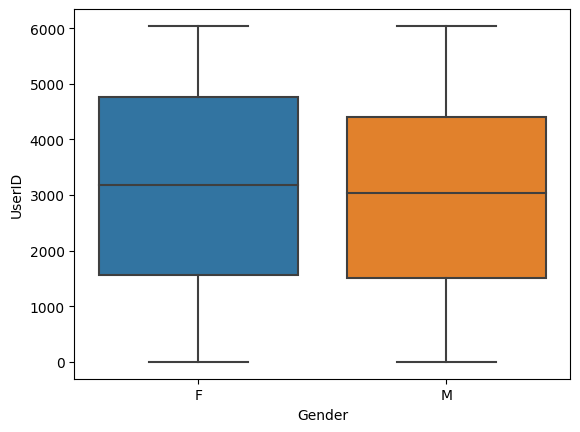

In [43]:
sns.boxplot(x='Gender', y='UserID', data=final_df)

<Axes: xlabel='Age', ylabel='UserID'>

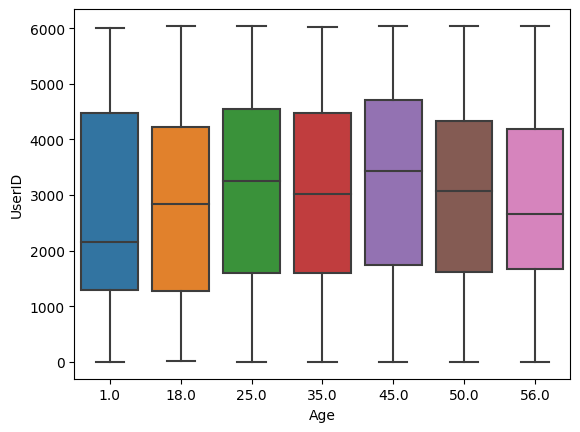

In [48]:
sns.boxplot(x='Age', y='UserID', data=final_df)

<Axes: xlabel='Rating', ylabel='UserID'>

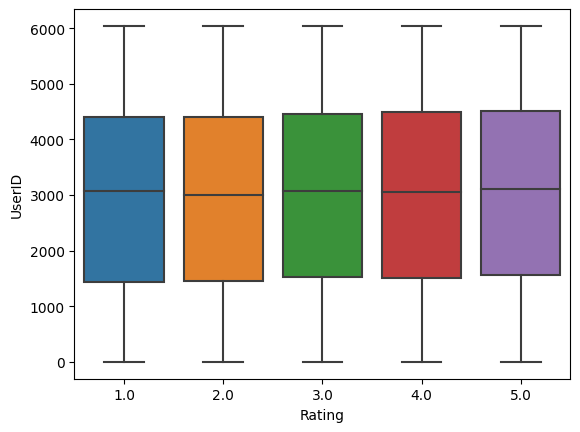

In [52]:
sns.boxplot(x='Rating', y='UserID', data=final_df)

##### To create a Recommender System, we will use Collaborative Filtering. Collaborative Filtering is a technique that makes recommendations based on the patterns of user ratings or behaviors.

In [63]:
# Create a pivot table
pivot = pd.pivot_table(final_df, values='Rating', index='UserID', columns='Title')


In [64]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the similarity between users
similarity = pd.DataFrame(cosine_similarity(pivot.fillna(0)))
similarity.index = pivot.index
similarity.columns = pivot.index


In [87]:
def recommend_movies(user_id, top_n=10):
    # Get the ratings of the given user
    user_ratings = pivot.loc[user_id].dropna()

    # Get the similarity between the given user and all other users
    user_similarity = similarity.loc[user_id]

    # Compute the weighted ratings of all other users
    weighted_ratings = pivot.apply(lambda x: x * user_similarity[x.name], axis=1).sum(axis=0).drop(user_ratings.index)

    # Get the top N recommended movies
    recommendations = weighted_ratings.sort_values(ascending=False).head(top_n)

    # Merge with movie information
    recommendations = pd.merge(recommendations.rename('rating'), final_df, on='Title')

    return recommendations[['UserID', 'Title', 'Genres']]


In [88]:
recommend_movies(1)

,UserID,Title,Genres
0,2.0,American Beauty (1999),Comedy|Drama
1,3.0,American Beauty (1999),Comedy|Drama
2,5.0,American Beauty (1999),Comedy|Drama
3,6.0,American Beauty (1999),Comedy|Drama
4,8.0,American Beauty (1999),Comedy|Drama
...,...,...,...
26666,6035.0,Shakespeare in Love (1998),Comedy|Romance
26667,6036.0,Shakespeare in Love (1998),Comedy|Romance
26668,6037.0,Shakespeare in Love (1998),Comedy|Romance
26669,6039.0,Shakespeare in Love (1998),Comedy|Romance


In [122]:
movie_count = final_df.MovieID.nunique()
movie_count

3706

In [129]:
# Aggregate by Movie

agg_ratings = final_df.groupby('Title').agg(mean_rating = ('Rating', 'mean'), number_of_ratings=('Rating', 'count')).reset_index()

In [131]:
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]

In [132]:
agg_ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2006 entries, 3 to 3705
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              2006 non-null   object 
 1   mean_rating        2006 non-null   float64
 2   number_of_ratings  2006 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 62.7+ KB


In [133]:
# Check popular movies
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,Title,mean_rating,number_of_ratings
127,American Beauty (1999),4.317386,3428
3153,Star Wars: Episode IV - A New Hope (1977),4.453694,2991
3154,Star Wars: Episode V - The Empire Strikes Back...,4.292977,2990
3155,Star Wars: Episode VI - Return of the Jedi (1983),4.022893,2883
1789,Jurassic Park (1993),3.763847,2672


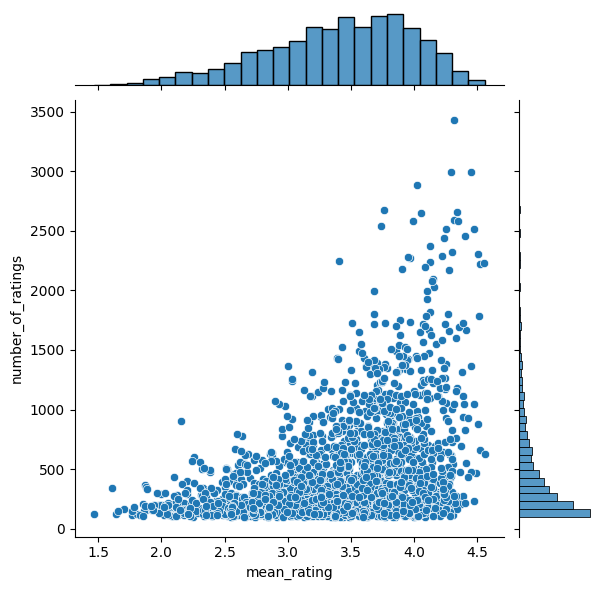

In [135]:
# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)
plt.show()

In [136]:
# Merge data
df_GT100 = pd.merge(final_df, agg_ratings_GT100[['Title']], on='Title', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 940925 entries, 0 to 940924
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   UserID      940925 non-null  float64
 1   Gender      940925 non-null  object 
 2   Age         940925 non-null  float64
 3   Occupation  940925 non-null  float64
 4   Zip-code    940925 non-null  object 
 5   MovieID     940925 non-null  int64  
 6   Rating      940925 non-null  float64
 7   Timestamp   940925 non-null  float64
 8   Title       940925 non-null  object 
 9   Genres      940925 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 79.0+ MB


In [137]:
# Number of users
print('The ratings dataset has', df_GT100['UserID'].nunique(), 'unique users')
# Number of movies
print('The ratings dataset has', df_GT100['MovieID'].nunique(), 'unique movies')
# Number of ratings
print('The ratings dataset has', df_GT100['Rating'].nunique(), 'unique ratings')
# List of unique ratings
print('The unique ratings are', sorted(df_GT100['Rating'].unique()))

The ratings dataset has 6040 unique users
The ratings dataset has 2006 unique movies
The ratings dataset has 5 unique ratings
The unique ratings are [1.0, 2.0, 3.0, 4.0, 5.0]


In [138]:
# Create user-item matrix
matrix = df_GT100.pivot_table(index='UserID', columns='Title', values='Rating')
matrix.head()

Title,"'burbs, The (1989)",...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",2 Days in the Valley (1996),20 Dates (1998),"20,000 Leagues Under the Sea (1954)",...,Yellow Submarine (1968),Yojimbo (1961),You've Got Mail (1998),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
UserID,,,,,,,,,,,,,,,,,,,,,
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

Title,"'burbs, The (1989)",...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",2 Days in the Valley (1996),20 Dates (1998),"20,000 Leagues Under the Sea (1954)",...,Yellow Submarine (1968),Yojimbo (1961),You've Got Mail (1998),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
UserID,,,,,,,,,,,,,,,,,,,,,
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.06,0.06,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
# User similarity matrix using Pearson correlation
user_similarity = matrix_norm.T.corr()
user_similarity.head()

UserID,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,6031.0,6032.0,6033.0,6034.0,6035.0,6036.0,6037.0,6038.0,6039.0,6040.0
UserID,,,,,,,,,,,,,,,,,,,,,
1.0,1.000000,0.416667,-0.332182,0.333333,-0.172516,0.219956,NaN,-0.583333,3.305715e-01,-0.057363,...,-0.160128,7.559289e-01,1.000000,NaN,0.381246,-0.201132,-4.517540e-01,NaN,0.056857,-0.043519
2.0,0.416667,1.000000,0.236834,-0.118678,-0.208333,-0.061859,0.154303,0.024968,2.051123e-01,-0.091578,...,-0.709299,9.083405e-02,0.301309,NaN,0.413063,0.377852,3.081451e-01,-0.500000,0.572078,-0.027143
3.0,-0.332182,0.236834,1.000000,0.840168,-0.437621,-0.349215,0.790569,-0.528594,-3.204938e-17,0.009305,...,-0.395285,-9.759001e-02,-0.711556,NaN,0.427001,0.204619,1.065328e-17,0.500000,0.309277,-0.395285
4.0,0.333333,-0.118678,0.840168,1.000000,0.000000,NaN,-0.207514,0.534522,5.222330e-01,-0.270501,...,-0.645497,2.266233e-17,-0.078598,NaN,-0.013558,0.467447,-1.132277e-01,-1.000000,0.000000,0.450323
5.0,-0.172516,-0.208333,-0.437621,0.000000,1.000000,-0.592014,-0.028516,0.218130,-1.538216e-17,-0.023582,...,0.260875,7.071068e-01,0.116775,0.5,0.539112,0.181292,-9.713482e-02,-0.928571,1.000000,0.322159


In [142]:
# User similarity matrix using cosine similarity
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
user_similarity_cosine

array([[ 1.        ,  0.03249804, -0.03474995, ...,  0.        ,
         0.01247323,  0.00598806],
       [ 0.03249804,  1.        ,  0.02253606, ..., -0.01310667,
         0.03349799, -0.00528243],
       [-0.03474995,  0.02253606,  1.        , ...,  0.04639292,
         0.05280115, -0.04427787],
       ...,
       [ 0.        , -0.01310667,  0.04639292, ...,  1.        ,
         0.04397604, -0.04092721],
       [ 0.01247323,  0.03349799,  0.05280115, ...,  0.04397604,
         1.        ,  0.0625175 ],
       [ 0.00598806, -0.00528243, -0.04427787, ..., -0.04092721,
         0.0625175 ,  1.        ]])

In [143]:
# Pick a user ID
picked_userid = 1
# Remove picked user ID from the candidate list
user_similarity.drop(index=picked_userid, inplace=True)
# Take a look at the data
user_similarity.head()

UserID,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,6031.0,6032.0,6033.0,6034.0,6035.0,6036.0,6037.0,6038.0,6039.0,6040.0
UserID,,,,,,,,,,,,,,,,,,,,,
2.0,0.416667,1.000000,0.236834,-0.118678,-0.208333,-0.061859,0.154303,0.024968,2.051123e-01,-0.091578,...,-0.709299,9.083405e-02,0.301309,NaN,0.413063,0.377852,3.081451e-01,-0.500000,0.572078,-0.027143
3.0,-0.332182,0.236834,1.000000,0.840168,-0.437621,-0.349215,0.790569,-0.528594,-3.204938e-17,0.009305,...,-0.395285,-9.759001e-02,-0.711556,NaN,0.427001,0.204619,1.065328e-17,0.500000,0.309277,-0.395285
4.0,0.333333,-0.118678,0.840168,1.000000,0.000000,NaN,-0.207514,0.534522,5.222330e-01,-0.270501,...,-0.645497,2.266233e-17,-0.078598,NaN,-0.013558,0.467447,-1.132277e-01,-1.000000,0.000000,0.450323
5.0,-0.172516,-0.208333,-0.437621,0.000000,1.000000,-0.592014,-0.028516,0.218130,-1.538216e-17,-0.023582,...,0.260875,7.071068e-01,0.116775,0.5,0.539112,0.181292,-9.713482e-02,-0.928571,1.000000,0.322159
6.0,0.219956,-0.061859,-0.349215,NaN,-0.592014,1.000000,0.866025,-0.590932,-2.374290e-01,0.324967,...,-0.693375,8.062258e-01,NaN,NaN,-0.385922,-0.318681,-2.721655e-01,-0.866025,-0.464973,0.056622


In [158]:
# Number of similar users
n = 10
# User similarity threashold
user_similarity_threshold = 0.3
# Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)
# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)

The similar users for user 1 are UserID
4991.0    1.000000
4339.0    1.000000
3111.0    1.000000
526.0     1.000000
5043.0    1.000000
            ...   
5477.0    0.301511
2353.0    0.301414
3503.0    0.301207
1928.0    0.300123
3638.0    0.300000
Name: 1.0, Length: 1217, dtype: float64


In [160]:
# Movies that the target user has watched
picked_userid_watched = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_watched.T

UserID,1.0
Title,
Airplane! (1980),-0.192308
Aladdin (1992),-0.192308
Antz (1998),-0.192308
Apollo 13 (1995),0.807692
Awakenings (1990),0.807692
Back to the Future (1985),0.807692
Bambi (1942),-0.192308
Beauty and the Beast (1991),0.807692
Ben-Hur (1959),0.807692


In [163]:
# Movies that similar users watched. Remove movies that none of the similar users have watched
similar_user_movies = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_movies

Title,"'burbs, The (1989)",...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",2 Days in the Valley (1996),20 Dates (1998),"20,000 Leagues Under the Sea (1954)",...,Yellow Submarine (1968),Yojimbo (1961),You've Got Mail (1998),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
UserID,,,,,,,,,,,,,,,,,,,,,
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.375,NaN,NaN,NaN
15.0,NaN,NaN,NaN,NaN,NaN,NaN,0.676617,NaN,NaN,NaN,...,NaN,NaN,-0.323383,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025.0,NaN,NaN,0.625498,NaN,-0.374502,NaN,NaN,NaN,NaN,NaN,...,0.625498,NaN,-0.374502,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6027.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6032.0,NaN,NaN,NaN,-0.138614,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.861386,NaN,NaN,NaN,NaN,NaN,NaN


In [164]:
# Remove the watched movie from the movie list
similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')
# Take a look at the data
similar_user_movies

Title,"'burbs, The (1989)",...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",2 Days in the Valley (1996),20 Dates (1998),"20,000 Leagues Under the Sea (1954)",...,Yellow Submarine (1968),Yojimbo (1961),You've Got Mail (1998),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
UserID,,,,,,,,,,,,,,,,,,,,,
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.375,NaN,NaN,NaN
15.0,NaN,NaN,NaN,NaN,NaN,NaN,0.676617,NaN,NaN,NaN,...,NaN,NaN,-0.323383,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025.0,NaN,NaN,0.625498,NaN,-0.374502,NaN,NaN,NaN,NaN,NaN,...,0.625498,NaN,-0.374502,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6027.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6032.0,NaN,NaN,NaN,-0.138614,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.861386,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
# A dictionary to store item scores
item_score = {}
# Loop through items
for i in similar_user_movies.columns:
  # Get the ratings for movie i
  movie_rating = similar_user_movies[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * movie_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count
# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])
    
# Sort the movies by score
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)
# Select top m movies
m = 10
ranked_item_score.head(m)

,movie,movie_score
712,"Godfather, The (1972)",0.415759
1574,"Shawshank Redemption, The (1994)",0.414340
1853,"Usual Suspects, The (1995)",0.378966
1337,Persuasion (1995),0.367859
744,"Great Escape, The (1963)",0.366117
1554,Seven Samurai (The Magnificent Seven) (Shichin...,0.361506
1426,Raiders of the Lost Ark (1981),0.355097
43,After Life (1998),0.354840
355,"City of Lost Children, The (1995)",0.352251
263,Braveheart (1995),0.351645


In [166]:
# Average rating for the picked user
avg_rating = matrix[matrix.index == picked_userid].T.mean()[picked_userid]
# Print the average movie rating for user 1
print(f'The average movie rating for user {picked_userid} is {avg_rating:.2f}')

The average movie rating for user 1 is 4.19


In [167]:
# Calcuate the predicted rating
ranked_item_score['predicted_rating'] = ranked_item_score['movie_score'] + avg_rating
# Take a look at the data
ranked_item_score.head(m)

,movie,movie_score,predicted_rating
712,"Godfather, The (1972)",0.415759,4.608067
1574,"Shawshank Redemption, The (1994)",0.414340,4.606648
1853,"Usual Suspects, The (1995)",0.378966,4.571274
1337,Persuasion (1995),0.367859,4.560166
744,"Great Escape, The (1963)",0.366117,4.558425
1554,Seven Samurai (The Magnificent Seven) (Shichin...,0.361506,4.553814
1426,Raiders of the Lost Ark (1981),0.355097,4.547405
43,After Life (1998),0.354840,4.547148
355,"City of Lost Children, The (1995)",0.352251,4.544558
263,Braveheart (1995),0.351645,4.543953
